# Autocloud trip graphs

This notebook contains the step-by-step code used to generate the graphics present in the README of this repository.

To run the notebook, it is recommended that you create a virtual environment and run the `pip install -r requirements.txt` command to install the necessary dependencies.

In [ ]:
# !pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
sns.set_theme(palette="pastel")

## 2012 Honda Fit

In [2]:
columns = ["engineLoad", "engineRPM", "speedOBD", "throttlePosManifold", "latitude", "longitude", "areas", "cloud_index"]
df_honda = pd.read_csv("./fit_trip.csv", usecols=columns)
df_honda.head()

,engineLoad,throttlePosManifold,speedOBD,engineRPM,latitude,longitude,areas,cloud_index
0,32.0,15.0,16.0,7.81,NaN,NaN,547.44,0.0
1,32.0,15.0,16.0,7.84,-5.843676,-35.198215,548.16,0.0
2,30.0,15.0,16.0,8.03,-5.843672,-35.198257,529.69,NaN
3,32.0,15.0,15.0,7.86,-5.843670,-35.198288,537.21,2.0
4,29.0,15.0,15.0,7.70,-5.843665,-35.198341,499.40,NaN


In [3]:
# get the dataset without nan values
honda_map = df_honda[df_honda.latitude.notna()]
honda_map = honda_map[honda_map.cloud_index.notna()]

In [4]:
import folium
from folium import plugins
import numpy as np
from folium.plugins import FloatImage

# Suponha que você tenha três clusters com as seguintes descrições
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Seu código para criar o mapa
m = folium.Map(location=[honda_map.latitude.mean(), honda_map.longitude.mean()], zoom_start=15)

# Colorir os clusters
colors = ["blue", 'green', 'red']

# Lista para armazenar as coordenadas para a AntPath
locations = []

for i, row in honda_map.iterrows():
    if not np.isnan(row['cloud_index']):
        folium.CircleMarker(
            [row['latitude'], row['longitude']], 
            radius=5, 
            color=colors[int(row['cloud_index'])], 
            fill=True
        ).add_to(m)
        locations.append([row['latitude'], row['longitude']])

# Adicionar marcador para o ponto inicial
folium.Marker(
    location=[honda_map.iloc[0]['latitude'], honda_map.iloc[0]['longitude']],
    popup='Start',
    icon=folium.Icon(icon="cloud"),
).add_to(m)

# Adicionar marcador para o ponto final
folium.Marker(
    location=[honda_map.iloc[-1]['latitude'], honda_map.iloc[-1]['longitude']],
    popup='End',
    icon=folium.Icon(color="red"),
).add_to(m)

# Adicionar a legenda
legend_html = """
     <div style="position: fixed; 
                 top: 50px; right: 50px; width: 120px; height: 150px; 
                 border:5px solid black; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp; <b>Legend</b> <br>
                  &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Cluster 0<br>
                  &nbsp; <i class="fa fa-circle" style="color:green"></i>&nbsp; Cluster 1<br>
                  &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; Cluster 2<br>
                  &nbsp; <i class="fa fa-map-marker" style="color:#3FAADA"></i>&nbsp; Start<br>
                  &nbsp; <i class="fa fa-map-marker" style="color:#D33F31"></i>&nbsp; End<br>
                  &nbsp; <i class="fa fa-arrow-up" style="color:#3FAADA"></i>&nbsp; Direction
      </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# Save to html
m.save('honda_map.html')


In [5]:
fit_metrics = df_honda[df_honda.cloud_index.notna()]

In [6]:
from sklearn.metrics import silhouette_score

ss = silhouette_score(fit_metrics[['areas', 'engineLoad']], fit_metrics['cloud_index'])
print(f"Silhouette Score: {round(ss, 4)}")

Silhouette Score: 0.0137


In [7]:
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(fit_metrics[['areas', 'engineLoad']], fit_metrics['cloud_index'])
print(f"Davies Bouldin Score: {round(dbs, 4)}")

Davies Bouldin Score: 35.3533


In [8]:
from sklearn.metrics import calinski_harabasz_score

chs = calinski_harabasz_score(fit_metrics[['areas', 'engineLoad']], fit_metrics['cloud_index'])
print(f"Calinski Harabasz Score: {round(chs, 4)}")

Calinski Harabasz Score: 22.9093


In [9]:
from sklearn.metrics import pairwise_distances
import numpy as np

def dunn_index(X, labels):
    """
    Calculate the Dunn index.

    Parameters:
    - X: array-like or matrix, shape (n_samples, n_features)
        The data.
    - labels: array-like, shape (n_samples,)
        Cluster labels for each sample.

    Returns:
    - float
        The value of the Dunn index.
    """
    # Caculate the pairwise distance between the points
    distances = pairwise_distances(X)

    # Initialize the maximum intracluster distance and the minimum intercluster distance
    max_intracluster_distance = 0
    min_intercluster_distance = float('inf')

    unique_labels = np.unique(labels)

    # Calculate the maximum intracluster distance and the minimum intercluster distance
    for label in unique_labels:
        cluster_points = X[labels == label]

        # Max istance intra-cluster
        intracluster_distance = np.max(pairwise_distances(cluster_points))
        if intracluster_distance > max_intracluster_distance:
            max_intracluster_distance = intracluster_distance

        # Min distance inter-cluster
        for other_label in unique_labels:
            if label != other_label:
                other_cluster_points = X[labels == other_label]
                intercluster_distance = np.min(pairwise_distances(cluster_points, other_cluster_points))
                if intercluster_distance < min_intercluster_distance:
                    min_intercluster_distance = intercluster_distance

    # Calculate the Dunn index
    dunn_index = min_intercluster_distance / max_intracluster_distance

    return dunn_index


di = dunn_index(fit_metrics[['areas', 'engineLoad']], fit_metrics['cloud_index'])
print(f"Dunn Index: {round(di, 4)}")

Dunn Index: 0.0000


/var/folders/dd/902tmbkn4cl692b0y7460zgw0000gn/T/ipykernel_1606/1812633548.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(group['areas'].mean(), group['engineLoad'].mean(), marker='x', s=100, label=f"Cloud {i}", c=palette[int(i)])


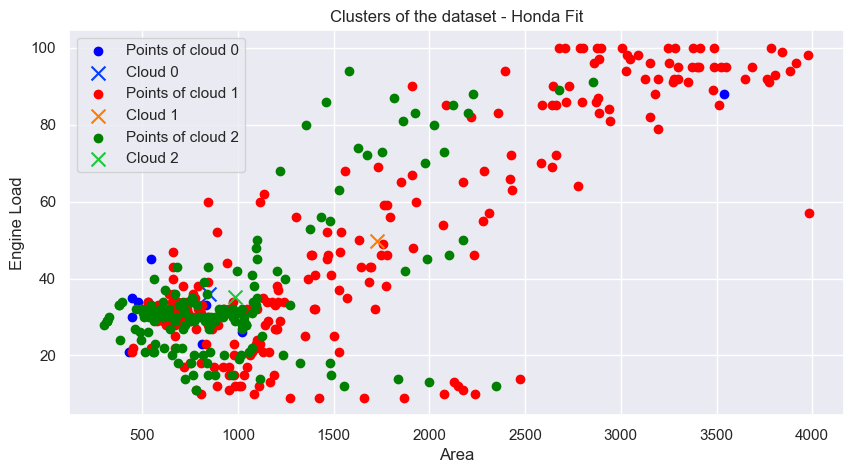

In [373]:
# plot the graph of the clusters
plt.figure(figsize=(10, 5))
# plt.scatter(tmp['areas'], tmp['engineLoad'], c=tmp['cloud_index'], label='Clusters')
point_colors = ["blue", 'red', 'green']

palette = sns.color_palette("bright", 3)

# plot the centers of the clusters
grouped = fit_metrics.groupby('cloud_index')
for i, group in grouped:
    i = int(i)
    plt.scatter(group['areas'], group['engineLoad'], c=point_colors[int(i)], label=f"Points of cloud {i}")
    plt.scatter(group['areas'].mean(), group['engineLoad'].mean(), marker='x', s=100, label=f"Cloud {i}", c=palette[int(i)])

plt.xlabel('Area')
plt.ylabel('Engine Load')
plt.title('Clusters of the dataset - Honda Fit')
plt.legend()
plt.show()

## 2014 Ford Fiesta

In [10]:
columns = ["engineLoad", "engineRPM", "speedOBD", "throttlePosManifold", "latitude", "longitude", "areas", "cloud_index"]
df_fiesta = pd.read_csv("./fiesta_trip.csv", usecols=columns)
df_fiesta.head()

,engineLoad,throttlePosManifold,speedOBD,engineRPM,latitude,longitude,areas,cloud_index
0,52.0,14.0,16.0,10.14,NaN,NaN,820.760,0.0
1,61.0,12.0,13.0,9.69,-5.843622,-35.198463,802.530,0.0
2,62.0,11.0,11.0,9.19,-5.843631,-35.198490,736.935,NaN
3,63.0,14.0,11.0,9.01,-5.843650,-35.198517,851.370,NaN
4,61.0,14.0,9.0,8.97,-5.843675,-35.198532,803.950,2.0


In [11]:
# get the dataset without nan values
fiesta_map = df_fiesta[df_fiesta.latitude.notna()]
fiesta_map = fiesta_map[fiesta_map.cloud_index.notna()]

In [12]:
import folium
from folium import plugins
import numpy as np

# Suponha que você tenha três clusters com as seguintes descrições
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Seu código para criar o mapa
m = folium.Map(location=[fiesta_map.latitude.mean(), fiesta_map.longitude.mean()], zoom_start=15)

# Colorir os clusters
colors = ['blue', 'green', "red"]

for i, row in fiesta_map.iterrows():
    if not np.isnan(row['cloud_index']):
        folium.CircleMarker(
            [row['latitude'], row['longitude']], 
            radius=5, 
            color=colors[int(row['cloud_index'])], 
            fill=True
        ).add_to(m)

# Adicionar marcador para o ponto inicial
folium.Marker(
    location=[fiesta_map.iloc[0]['latitude'], fiesta_map.iloc[0]['longitude']],
    popup='Start',
    icon=folium.Icon(icon="cloud"),
).add_to(m)

# Adicionar marcador para o ponto final
folium.Marker(
    location=[fiesta_map.iloc[-1]['latitude'], fiesta_map.iloc[-1]['longitude']],
    popup='End',
    icon=folium.Icon(color="red"),
).add_to(m)

# Add legend
legend_html = """
     <div style="position: fixed; 
                 top: 50px; right: 50px; width: 120px; height: 150px; 
                 border:5px solid black; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp; <b>Legend</b> <br>
                  &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Cluster 0<br>
                  &nbsp; <i class="fa fa-circle" style="color:green"></i>&nbsp; Cluster 1<br>
                  &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; Cluster 2<br>
                  &nbsp; <i class="fa fa-map-marker" style="color:#3FAADA"></i>&nbsp; Start<br>
                  &nbsp; <i class="fa fa-map-marker" style="color:#D33F31"></i>&nbsp; End<br>
                  &nbsp; <i class="fa fa-arrow-up" style="color:#3FAADA"></i>&nbsp; Direction
      </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# Save to html
m.save('fiesta_map.html')

In [13]:
fiesta_metrics = df_fiesta[df_fiesta.cloud_index.notna()]

In [14]:
from sklearn.metrics import silhouette_score

ss = silhouette_score(fiesta_metrics[['areas', 'engineLoad']], fiesta_metrics['cloud_index'])
print(f"Silhouette Score: {round(ss, 4)}")

Silhouette Score: 0.1550


In [15]:
from sklearn.metrics import davies_bouldin_score

dbs = davies_bouldin_score(fiesta_metrics[['areas', 'engineLoad']], fiesta_metrics['cloud_index'])
print(f"Davies Bouldin Score: {round(dbs, 4)}")

Davies Bouldin Score: 9.2052


In [16]:
from sklearn.metrics import calinski_harabasz_score

chs = calinski_harabasz_score(fiesta_metrics[['areas', 'engineLoad']], fiesta_metrics['cloud_index'])
print(f"Calinski Harabasz Score: {round(chs, 4)}")

Calinski Harabasz Score: 13.6478


In [18]:
from sklearn.metrics import pairwise_distances
import numpy as np

def dunn_index(X, labels):
    """
    Calculate the Dunn index.

    Parameters:
    - X: array-like or matrix, shape (n_samples, n_features)
        The data.
    - labels: array-like, shape (n_samples,)
        Cluster labels for each sample.

    Returns:
    - float
        The value of the Dunn index.
    """
    # Caculate the pairwise distance between the points
    distances = pairwise_distances(X)

    # Initialize the maximum intracluster distance and the minimum intercluster distance
    max_intracluster_distance = 0
    min_intercluster_distance = float('inf')

    unique_labels = np.unique(labels)

    # Calculate the maximum intracluster distance and the minimum intercluster distance
    for label in unique_labels:
        cluster_points = X[labels == label]

        # Max istance intra-cluster
        intracluster_distance = np.max(pairwise_distances(cluster_points))
        if intracluster_distance > max_intracluster_distance:
            max_intracluster_distance = intracluster_distance

        # Min distance inter-cluster
        for other_label in unique_labels:
            if label != other_label:
                other_cluster_points = X[labels == other_label]
                intercluster_distance = np.min(pairwise_distances(cluster_points, other_cluster_points))
                if intercluster_distance < min_intercluster_distance:
                    min_intercluster_distance = intercluster_distance

    # Calculate the Dunn index
    dunn_index = min_intercluster_distance / max_intracluster_distance

    return dunn_index


di = dunn_index(fiesta_metrics[['areas', 'engineLoad']], fiesta_metrics['cloud_index'])
print(f"Dunn Index: {round(di, 4)}")

Dunn Index: 0.0002


/var/folders/dd/902tmbkn4cl692b0y7460zgw0000gn/T/ipykernel_1606/4035045032.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(group['areas'].mean(), group['engineLoad'].mean(), marker='x', s=100, label=f"Cloud {i}", c=palette[int(i)])


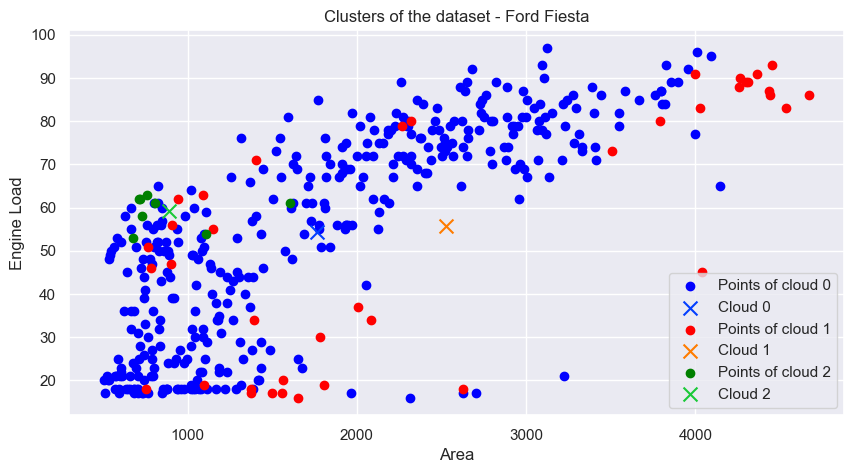

In [324]:
# plot the graph of the clusters
plt.figure(figsize=(10, 5))
# plt.scatter(fiesta_metrics['areas'], fiesta_metrics['engineLoad'], c=fiesta_metrics['cloud_index'], label='Clusters')
point_colors = ["blue", 'red', 'green']

palette = sns.color_palette("bright", 3)

# plot the centers of the clusters
grouped = fiesta_metrics.groupby('cloud_index')
for i, group in grouped:
    i = int(i)
    plt.scatter(group['areas'], group['engineLoad'], c=point_colors[int(i)], label=f"Points of cloud {i}")
    plt.scatter(group['areas'].mean(), group['engineLoad'].mean(), marker='x', s=100, label=f"Cloud {i}", c=palette[int(i)])

plt.xlabel('Area')
plt.ylabel('Engine Load')
plt.title('Clusters of the dataset - Ford Fiesta')
plt.legend()
plt.show()